In [12]:
#Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization,GlobalAveragePooling2D,ReLU,Input,multiply,Layer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.metrics import Precision,Recall


### Data Preparation

In [3]:
train_path = "./data/train"
valid_path = "./data/valid"
test_path = "/test"

In [ ]:
file_train = []
label_train = []
folds = os.listdir(train_path)

for fold in folds:
    fold_path = os.path.join(train_path, fold)
    files= os.listdir(fold_path)
    for file in tqdm(files):
        img_path = os.path.join(fold_path, file)
        file_train.append(img_path)
        label_train.append(fold)

100%|██████████| 1961/1961 [00:00<00:00, 490110.25it/s]


In [5]:
file_valid = []
label_valid = []

folds = os.listdir(valid_path)

for fold in folds:
    fold_path = os.path.join(valid_path, fold)
    files = os.listdir(fold_path)
    for file in tqdm(files):
        filepath= os.path.join(fold_path,file)
        file_valid.append(filepath)
        label_valid.append(fold)

100%|██████████| 490/490 [00:00<00:00, 489568.59it/s]


In [6]:
df_train = pd.DataFrame({
    "filename" : file_train,
    "label" : label_train
    })
df_valid = pd.DataFrame({
    "filename" : file_valid,
    "label" : label_valid
})

In [8]:
df_train.head()

,filename,label
0,./data/train\Apple___Apple_scab\00075aa8-d81a-...,Apple___Apple_scab
1,./data/train\Apple___Apple_scab\01a66316-0e98-...,Apple___Apple_scab
2,./data/train\Apple___Apple_scab\01a66316-0e98-...,Apple___Apple_scab
3,./data/train\Apple___Apple_scab\01a66316-0e98-...,Apple___Apple_scab
4,./data/train\Apple___Apple_scab\01a66316-0e98-...,Apple___Apple_scab


In [6]:
df_valid.head()

,filename,label
0,./data/valid\Apple___Apple_scab\00075aa8-d81a-...,Apple___Apple_scab
1,./data/valid\Apple___Apple_scab\00075aa8-d81a-...,Apple___Apple_scab
2,./data/valid\Apple___Apple_scab\00075aa8-d81a-...,Apple___Apple_scab
3,./data/valid\Apple___Apple_scab\01f3deaa-6143-...,Apple___Apple_scab
4,./data/valid\Apple___Apple_scab\0208f4eb-45a4-...,Apple___Apple_scab


In [7]:
df_train.shape

(70295, 2)

In [8]:
df_valid.shape

(17572, 2)

### Data Visualization

In [9]:
plt.figure(figsize=(30,9))


<Figure size 3000x900 with 0 Axes>

<Figure size 3000x900 with 0 Axes>

### data preprocessing / Augmentation

In [ ]:
# normalize and augmentate training data
data_gen = ImageDataGenerator(
    rescale=1./255,
    zoom_range = 0.2,
    horizontal_flip=True,
    rotation_range=20
)
# only normalize test data
test_gen = ImageDataGenerator(rescale=1./255)
img_size = (224,224)
batch_size = 32

In [ ]:
train_gen = data_gen.flow_from_dataframe(
    df_train,
    x_col ="filename",
    shuffle = True,
    y_col = "label",
    target_size = (img_size[0],img_size[1]),
    class_mode = "categorical",
    batch_size = batch_size
)

valid_gen = test_gen.flow_from_dataframe(
    df_valid,
    x_col ="filename",
    shuffle = False,
    y_col = "label",
    target_size = (img_size[0],img_size[1]),
    class_mode = "categorical"
)

Found 70295 validated image filenames belonging to 38 classes.
Found 17572 validated image filenames belonging to 38 classes.


In [12]:
label_dict=train_gen.class_indices

In [13]:
label_dict

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Blueberry___healthy': 4,
 'Cherry_(including_sour)___Powdery_mildew': 5,
 'Cherry_(including_sour)___healthy': 6,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7,
 'Corn_(maize)___Common_rust_': 8,
 'Corn_(maize)___Northern_Leaf_Blight': 9,
 'Corn_(maize)___healthy': 10,
 'Grape___Black_rot': 11,
 'Grape___Esca_(Black_Measles)': 12,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13,
 'Grape___healthy': 14,
 'Orange___Haunglongbing_(Citrus_greening)': 15,
 'Peach___Bacterial_spot': 16,
 'Peach___healthy': 17,
 'Pepper,_bell___Bacterial_spot': 18,
 'Pepper,_bell___healthy': 19,
 'Potato___Early_blight': 20,
 'Potato___Late_blight': 21,
 'Potato___healthy': 22,
 'Raspberry___healthy': 23,
 'Soybean___healthy': 24,
 'Squash___Powdery_mildew': 25,
 'Strawberry___Leaf_scorch': 26,
 'Strawberry___healthy': 27,
 'Tomato___Bacterial_spot': 28,
 'Tomato___Early_blight': 29,
 'Toma

### Modeling

In [17]:
input_shape=(224, 224, 3) 
num_classes=38


### Input → GlobalAvgPool → [Dense → ReLU] → [Dense → Sigmoid] → Channel-wise Multiplication

In [ ]:
cnn = Sequential()
#Initial block
cnn.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
cnn.add(Conv2D(32, (3,3), activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D((2,2)))

#Intermediate Block
cnn.add(Conv2D(64, (3,3), activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(2,2))

cnn.add(Conv2D(128,(3,3),activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(2,2))

#Deep Feature Extraction Block

cnn.add(Conv2D(256,(3,3),activation="relu",padding="same"))
cnn.add(BatchNormalization())
cnn.add(Conv2D(256,(3,3),activation="relu",padding="same"))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(2,2))

#Last layer

cnn.add(GlobalAveragePooling2D())
cnn.add(Dropout(0.5))
cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(num_classes,activation= "softmax"))

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### post train quantization



In [21]:

converter = tf.lite.TFLiteConverter.from_keras_model(cnn)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp729kbdk0\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp729kbdk0\assets


Saved artifact at 'C:\Users\USER\AppData\Local\Temp\tmp729kbdk0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 38), dtype=tf.float32, name=None)
Captures:
  2159100669264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159100668880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159100670224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159100671376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159100669072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159100670800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159100670608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159100671568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159100673296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159100673104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  21591

In [16]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 220, 220, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 108, 108, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 26, 26, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,141,766 (4.36 MB)

 Trainable params: 1,140,294 (4.35 MB)

 Non-trainable params: 1,472 (5.75 KB)

### Training

In [ ]:

cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

In [18]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3
)
history = cnn.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=5,
    callbacks=[early_stop, reduce_lr],

)

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2975s 1s/step - accuracy: 0.4268 - loss: 2.0742 - precision: 0.7547 - recall: 0.2111 - val_accuracy: 0.7078 - val_loss: 0.9937 - val_precision: 0.7929 - val_recall: 0.6268 - learning_rate: 1.0000e-04
Epoch 2/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2876s 1s/step - accuracy: 0.7830 - loss: 0.7095 - precision: 0.8693 - recall: 0.6938 - val_accuracy: 0.8150 - val_loss: 0.5917 - val_precision: 0.8591 - val_recall: 0.7729 - learning_rate: 1.0000e-04
Epoch 3/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2687s 1s/step - accuracy: 0.8680 - loss: 0.4307 - precision: 0.9094 - recall: 0.8237 - val_accuracy: 0.7807 - val_loss: 0.7061 - val_precision: 0.8300 - val_recall: 0.7405 - learning_rate: 1.0000e-04
Epoch 4/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2485s 1s/step - accuracy: 0.9001 - loss: 0.3179 - precision: 0.9279 - recall: 0.8723 - val_accuracy: 0.7996 - val_loss: 0.6940 - val_precision: 0.8318 - val_recall: 0.7760 - learning_rate: 1.0000e-04
Epoch 5/5
2197/2197 ━━━━━━━━━━━━━━━━

In [22]:
cnn.save("plant_disease_model_V1.h5")

In [23]:
load_model = tf.keras.models.load_model("plant_disease_model_V1.h5")

In [34]:
y_true = valid_gen.classes
y_pred_prob = load_model.predict(valid_gen)
y_pred = np.argmax(y_pred_prob,axis=1)

550/550 ━━━━━━━━━━━━━━━━━━━━ 122s 222ms/step


In [35]:
class_names = list(valid_gen.class_indices.keys())
cm = confusion_matrix(y_true, y_pred)

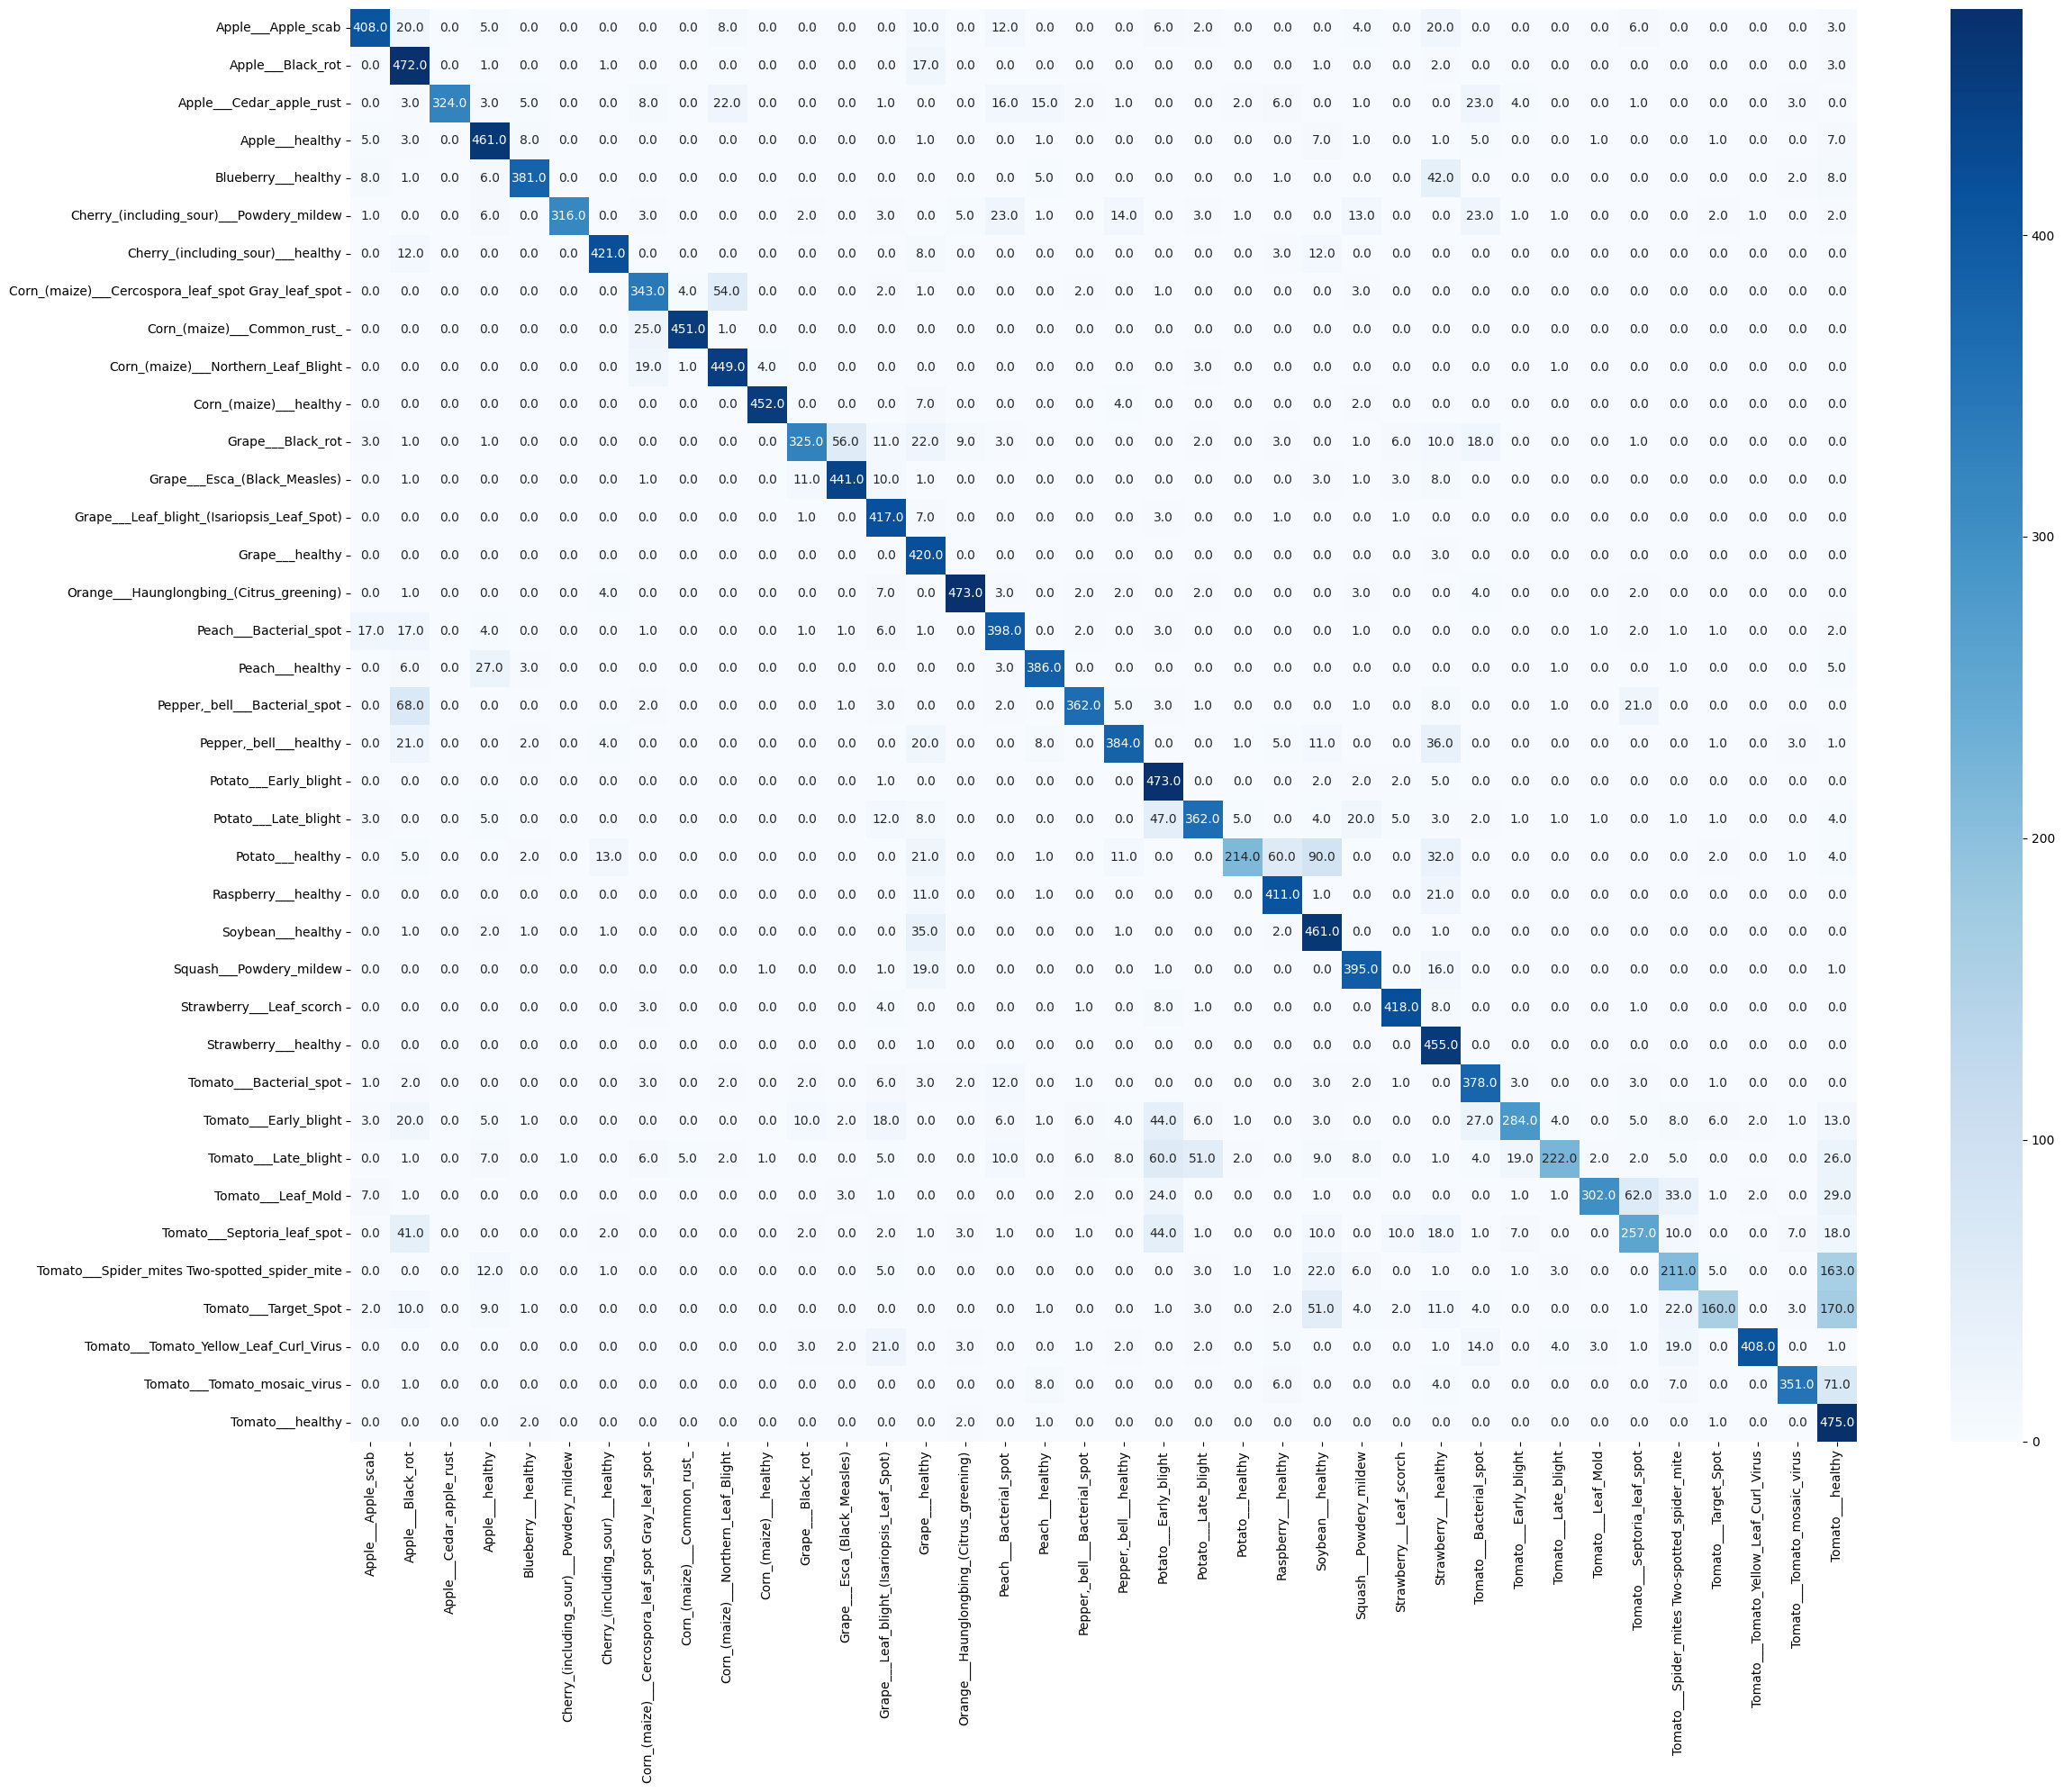

In [36]:
plt.figure(figsize=(25, 20))
sns.heatmap(cm, annot=True, fmt='.1f', cmap='Blues',xticklabels=class_names, yticklabels=class_names)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

In [39]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=2))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.89      0.81      0.85       504
                                 Apple___Black_rot       0.67      0.95      0.78       497
                          Apple___Cedar_apple_rust       1.00      0.74      0.85       440
                                   Apple___healthy       0.83      0.92      0.87       502
                               Blueberry___healthy       0.94      0.84      0.89       454
          Cherry_(including_sour)___Powdery_mildew       1.00      0.75      0.86       421
                 Cherry_(including_sour)___healthy       0.94      0.92      0.93       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.83      0.84      0.83       410
                       Corn_(maize)___Common_rust_       0.98      0.95      0.96       477
               Corn_(maize)___Northern_Leaf_Blight       0.83      0.94      0.

### Versions 2 With attention Mechanism